This notebook deals with the contents of Section 5.3 of the book.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Load and inspect data

In [2]:
df = pd.read_csv("data/data-attendance-3.txt")
print(len(df))
print(df.dtypes)
df.head(5)

2396
PersonID     int64
A            int64
Score        int64
Weather     object
Y            int64
dtype: object


,PersonID,A,Score,Weather,Y
0,1,0,69,B,1
1,1,0,69,A,1
2,1,0,69,C,1
3,1,0,69,A,1
4,1,0,69,B,1


In [3]:
pd.crosstab(df["Weather"], df["Y"])

Y,0,1
Weather,,
A,306,953
B,230,500
C,138,269


In [4]:
# exercise (3)
pd.crosstab(df["A"], df["Y"])

Y,0,1
A,,
0,288,994
1,386,728


# Run Stan

In [5]:
model = CmdStanModel(stan_file="model/model5-5.stan")
print(model)

INFO:cmdstanpy:compiling stan program, exe file: /workdir/chap05/model/model5-5
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /workdir/chap05/model/model5-5


CmdStanModel: name=model5-5
	 stan_file=/workdir/chap05/model/model5-5.stan
	 exe_file=/workdir/chap05/model/model5-5
	 compiler_optons=stanc_options=None, cpp_options=None


In [6]:
def weather_to_float(weather):
    if weather == 'A':
        return 0.0
    elif weather =='B':
        return 0.2
    elif weather == 'C':
        return 1.0

In [7]:
data = {
    "I" : len(df),
    "A" : df["A"].values,
    "Score" : df["Score"].values/200,
    "W" : np.vectorize(weather_to_float)(df["Weather"].values),
    "Y" : df["Y"].values
}

In [8]:
fit = model.sample(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


# Inspect the result

In [9]:
print(type(fit))
print(fit)

<class 'cmdstanpy.stanfit.CmdStanMCMC'>
CmdStanMCMC: model=model5-5 chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/tmp/tmpfpli_knc/model5-5-202010040522-1-l4p1d1rn.csv
	/tmp/tmpfpli_knc/model5-5-202010040522-2-a5duat4t.csv
	/tmp/tmpfpli_knc/model5-5-202010040522-3-iwuyn04h.csv
	/tmp/tmpfpli_knc/model5-5-202010040522-4-_saqog1s.csv
 output_files:
	/tmp/tmpfpli_knc/model5-5-202010040522-1-l4p1d1rn-stdout.txt
	/tmp/tmpfpli_knc/model5-5-202010040522-2-a5duat4t-stdout.txt
	/tmp/tmpfpli_knc/model5-5-202010040522-3-iwuyn04h-stdout.txt
	/tmp/tmpfpli_knc/model5-5-202010040522-4-_saqog1s-stdout.txt


In [10]:
print(fit.num_draws)
print(fit.draws().shape)

1000
(1000, 4, 2407)


In [11]:
fit.stan_variables()

{'b': array([[ 0.0400562, -0.593459 ,  2.12714  , -0.362435 ],
        [ 0.280311 , -0.662439 ,  1.90047  , -0.485903 ],
        [ 0.282589 , -0.678491 ,  1.9454   , -0.445746 ],
        ...,
        [ 0.296159 , -0.651128 ,  1.93523  , -0.577341 ],
        [ 0.188068 , -0.408981 ,  1.68789  , -0.569908 ],
        [ 0.2717   , -0.417517 ,  1.77905  , -0.501122 ]]),
 'q': array([[0.668505, 0.684368, 0.601444, ..., 0.622349, 0.53422 , 0.53422 ],
        [0.698211, 0.718286, 0.610656, ..., 0.63613 , 0.518168, 0.518168],
        [0.703622, 0.721869, 0.624339, ..., 0.638088, 0.530295, 0.530295],
        ...,
        [0.70022 , 0.723885, 0.595434, ..., 0.646336, 0.506407, 0.506407],
        [0.658453, 0.683605, 0.549953, ..., 0.648988, 0.511169, 0.511169],
        [0.68681 , 0.707955, 0.594922, ..., 0.675861, 0.558158, 0.558158]])}

In [12]:
fit_summary = fit.summary()
fit_summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-1383.09,0.038215,1.43271,-1385.91,-1382.76,-1381.41,1405.55,32.1424,1.00086
b[1],0.17,0.005900,0.23000,-0.22,0.17,0.56,1551.00,35.0000,1.00000
b[2],-0.62,0.002000,0.09400,-0.77,-0.62,-0.46,2282.00,52.0000,1.00000
b[3],2.00,0.009400,0.37000,1.30,2.00,2.60,1575.00,36.0000,1.00000
b[4],-0.46,0.002600,0.12000,-0.67,-0.47,-0.26,2260.00,52.0000,1.00000
...,...,...,...,...,...,...,...,...,...
q[2392],0.61,0.000370,0.01800,0.57,0.61,0.64,2457.00,56.0000,1.00000
q[2393],0.63,0.000380,0.01900,0.60,0.63,0.66,2529.00,58.0000,1.00000
q[2394],0.63,0.000380,0.01900,0.60,0.63,0.66,2529.00,58.0000,1.00000


In [13]:
# Check the convergence
fit_summary[fit_summary["R_hat"] >= 1.1]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,


In [14]:
print(fit.diagnose())

INFO:cmdstanpy:Processing csv files: /tmp/tmpfpli_knc/model5-5-202010040522-1-l4p1d1rn.csv, /tmp/tmpfpli_knc/model5-5-202010040522-2-a5duat4t.csv, /tmp/tmpfpli_knc/model5-5-202010040522-3-iwuyn04h.csv, /tmp/tmpfpli_knc/model5-5-202010040522-4-_saqog1s.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


Processing csv files: /tmp/tmpfpli_knc/model5-5-202010040522-1-l4p1d1rn.csv, /tmp/tmpfpli_knc/model5-5-202010040522-2-a5duat4t.csv, /tmp/tmpfpli_knc/model5-5-202010040522-3-iwuyn04h.csv, /tmp/tmpfpli_knc/model5-5-202010040522-4-_saqog1s.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


# Plot the result

In [15]:
q_percentiles = np.percentile(fit.stan_variable("q"), [10.0, 50.0, 90.0], axis=0)
q_percentiles.shape

(3, 2396)

Text(0, 0.5, 'q')

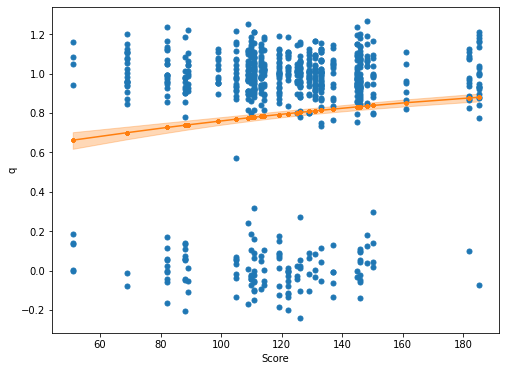

In [16]:
# Fig 5.9
# Plot score vs q (for weather = 'A' and 'A' = 0 only)

df_tmp = df.sort_values(by=["Score"])[["Weather", "A"]]
idx = df_tmp[(df_tmp["Weather"] == 'A') & (df_tmp['A'] == 0)].index.values

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

ax.plot(df["Score"][idx], df["Y"][idx] + 0.1*np.random.randn(len(idx)), 'o', markersize=5, color="C0")
ax.plot(df["Score"][idx], q_percentiles[1][idx], '.-', color="C1")
ax.fill_between(df["Score"][idx], q_percentiles[0][idx], q_percentiles[2][idx], alpha=0.3, color="C1")
ax.set_xlabel("Score")
ax.set_ylabel("q")

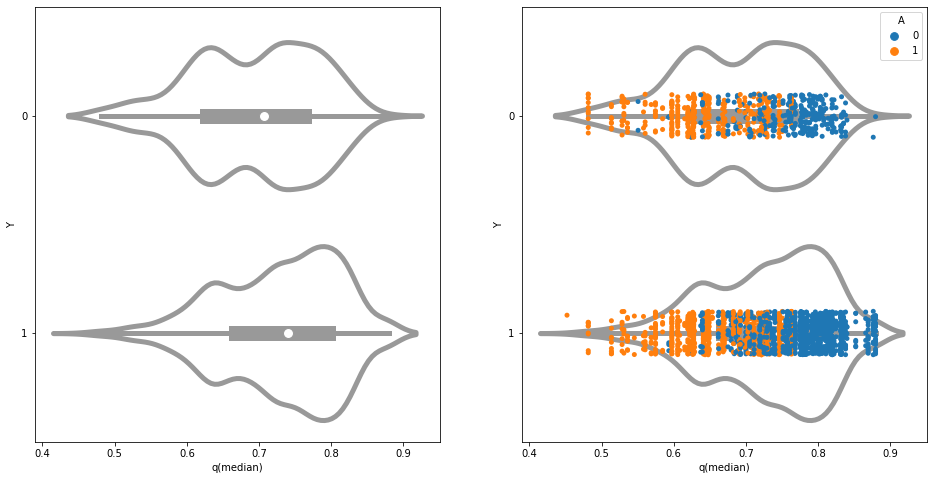

In [17]:
# Fig 5.10
# prob vs. observation

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax = axes[0]
sns.violinplot(x=q_percentiles[1], y=df["Y"], color='white', linewidth=5, orient='h', ax=ax)
ax.set_xlabel("q(median)")

ax = axes[1]
sns.violinplot(x=q_percentiles[1], y=df["Y"], color='white', linewidth=5, orient='h', ax=ax)
sns.stripplot(x=q_percentiles[1], y=df["Y"], hue=df["A"], orient='h', ax=ax)
ax.set_xlabel("q(median)")

plt.show()

ROC AUC Score : 0.6170155295236717


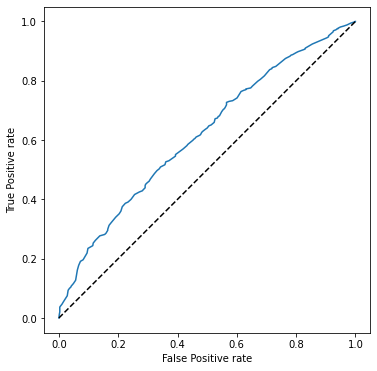

In [18]:
# Fig 5.11
# ROC curve : 

print("ROC AUC Score :", roc_auc_score(df["Y"].values, q_percentiles[1]))

fpr, tpr, thresholds = roc_curve(df["Y"].values, q_percentiles[1])
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], 'k--')
ax.set_aspect("equal")
ax.set_xlabel("False Positive rate")
ax.set_ylabel("True Positive rate")
plt.show()